# Path to data and example script

The eye tracking data and images for the latency shortening experiments is located under `/projects/nextcloud_data/Latency_shortening`. I've pasted and very slightly modified the contents of `/projects/nextcloud_data/Latency_shortening/plot_single_trial_gaze_trajectory.py` to try if out.

In [1]:
# If we don't want to plot all 473 trials in this jupyter notebook
n_trials_to_plot = 10

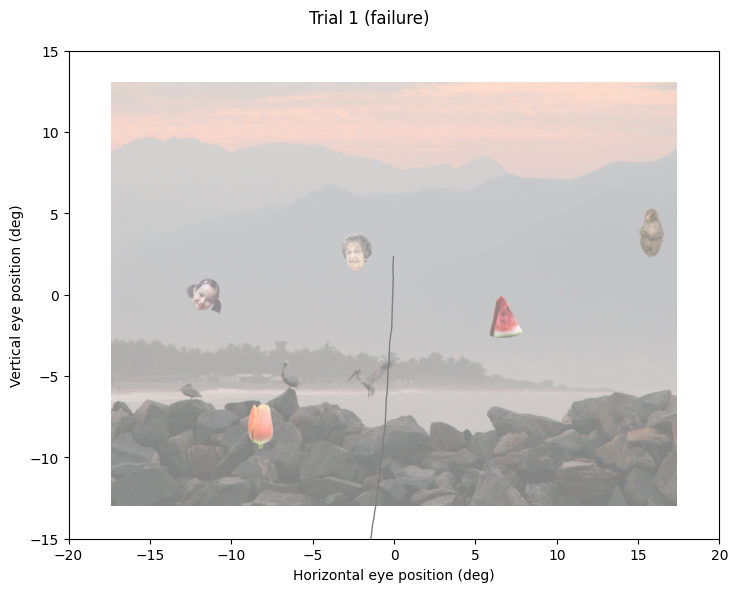

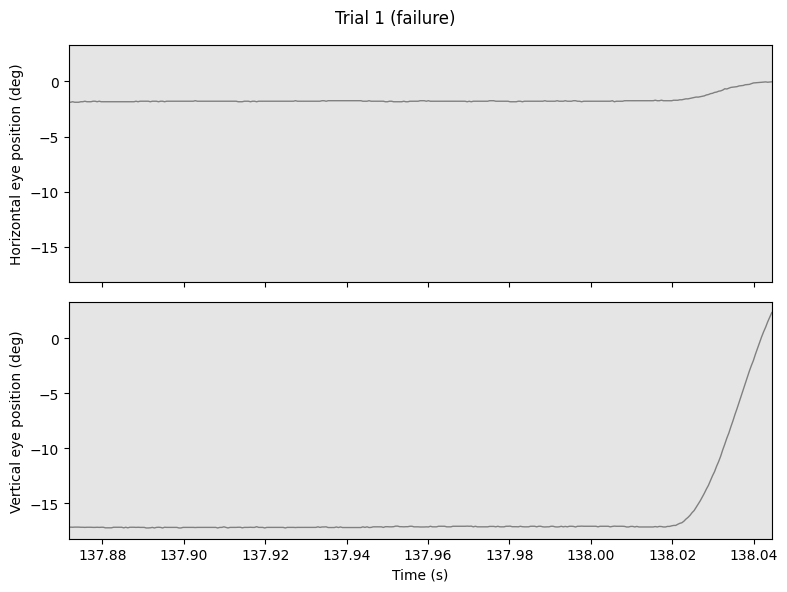

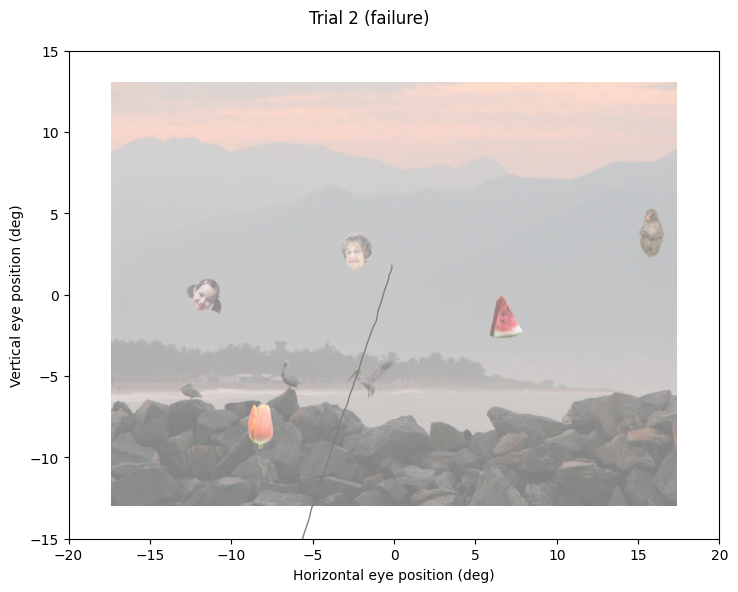

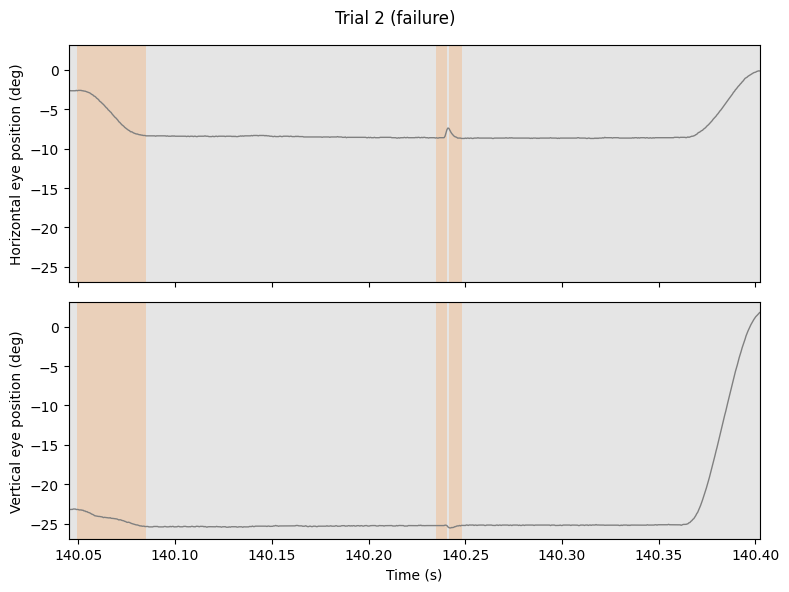

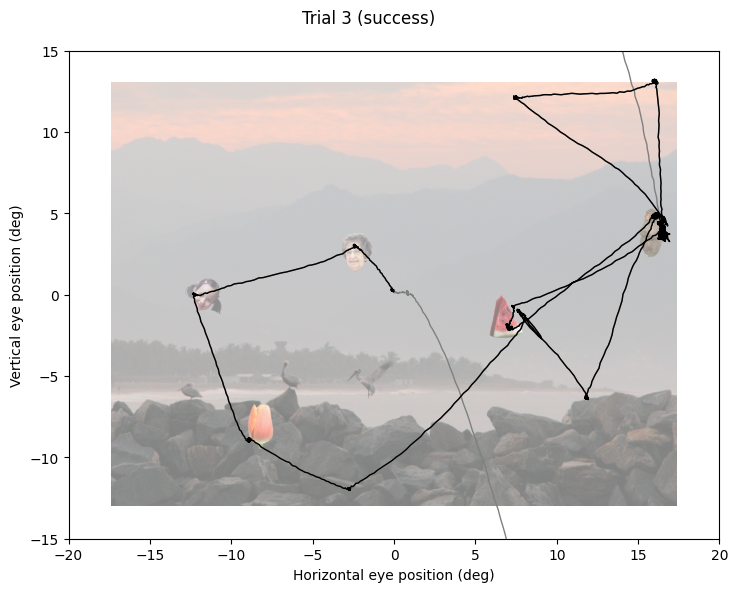

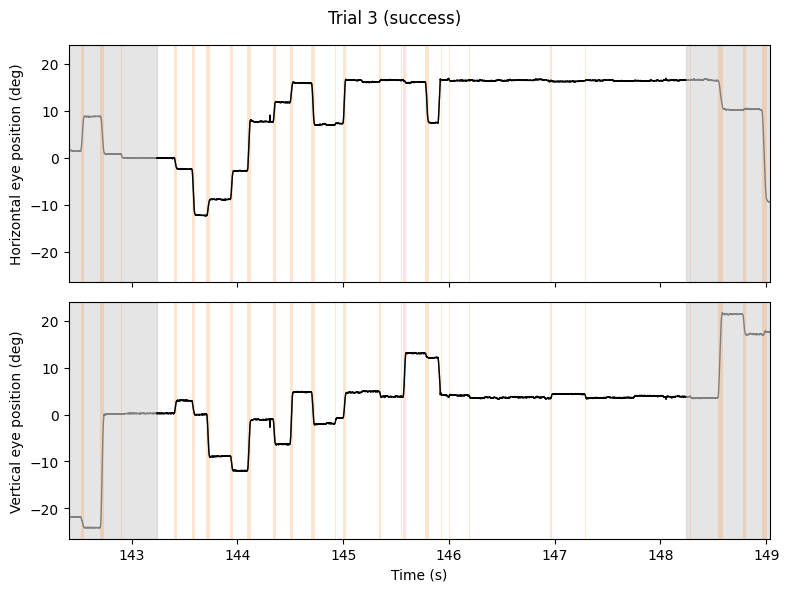

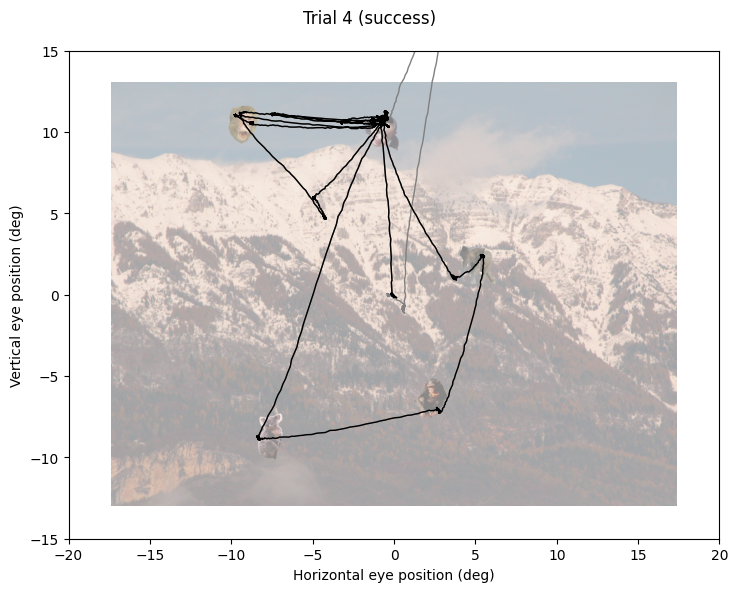

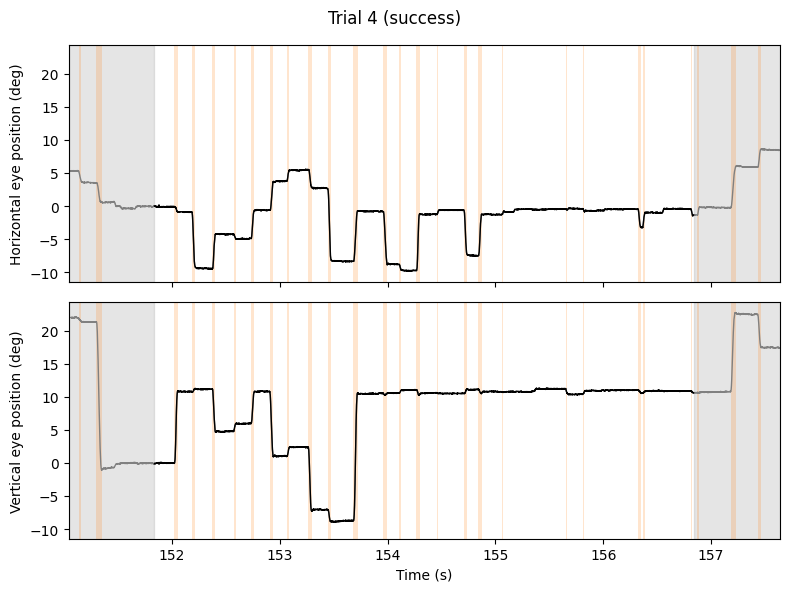

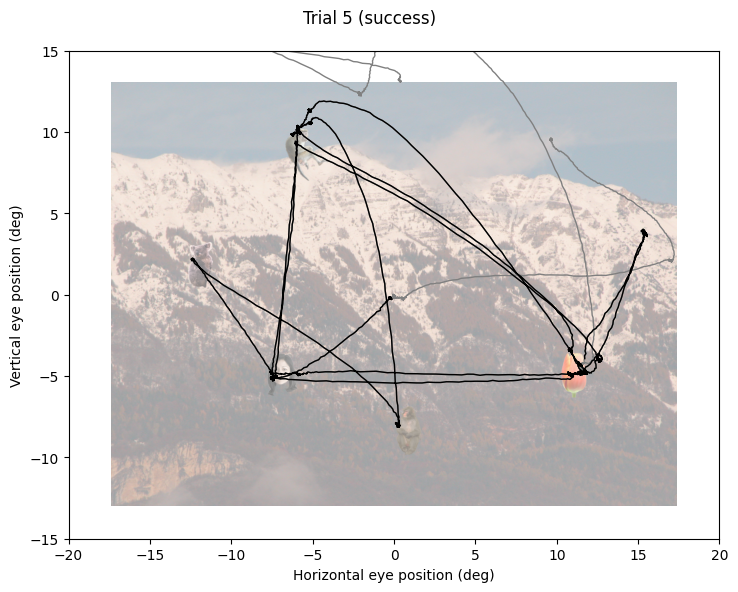

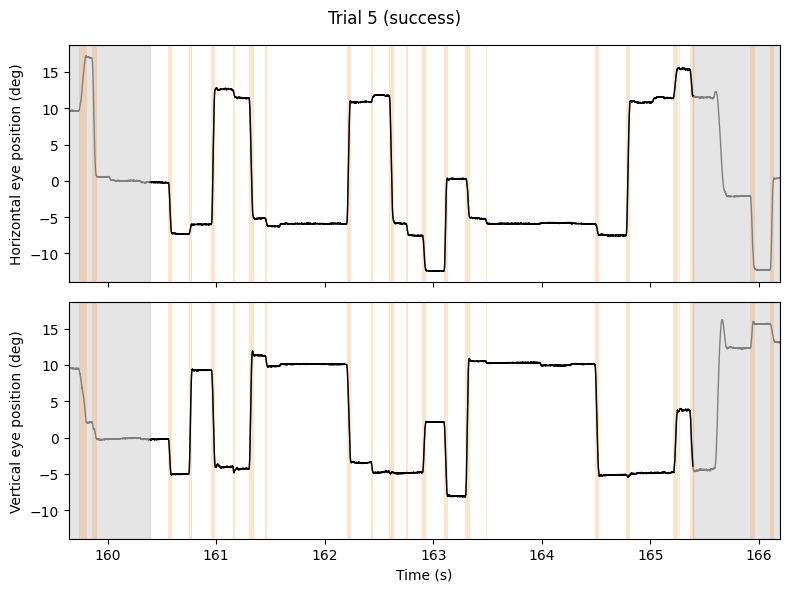

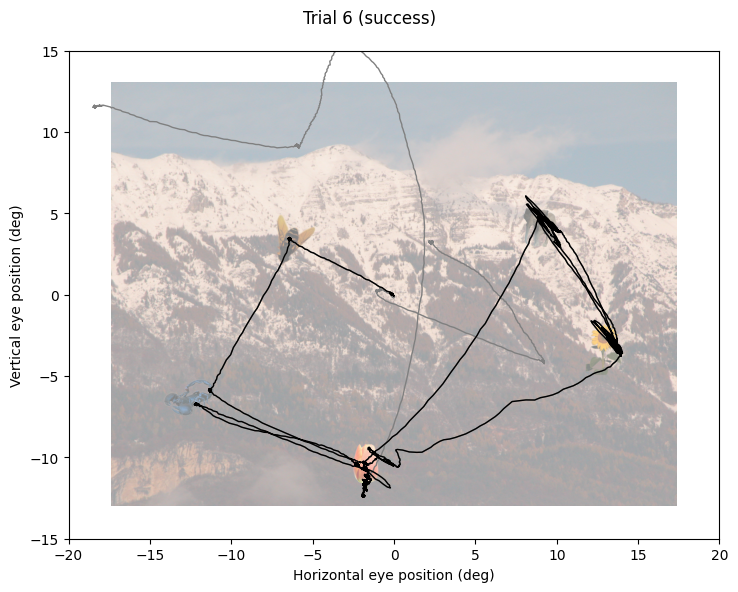

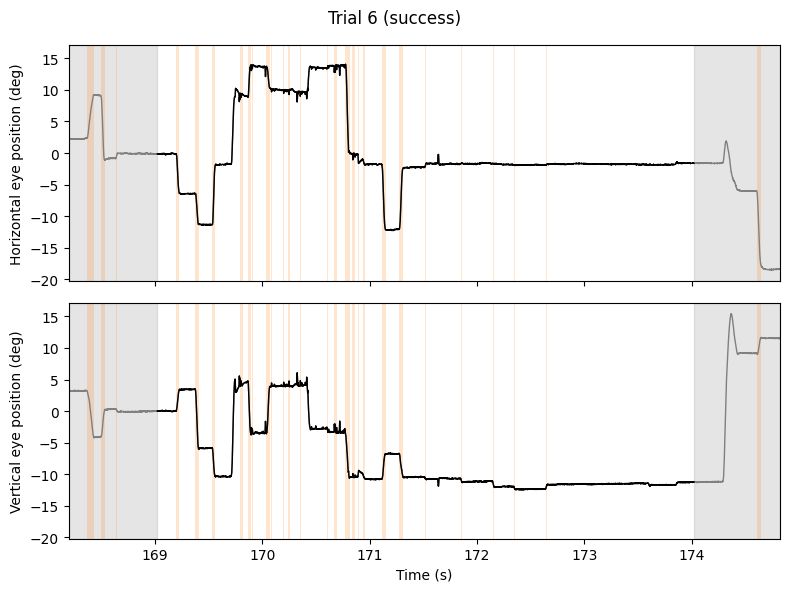

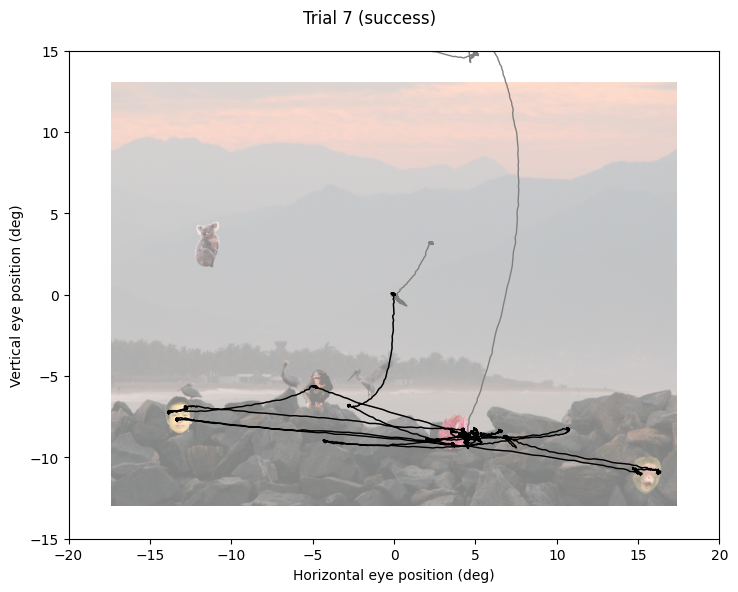

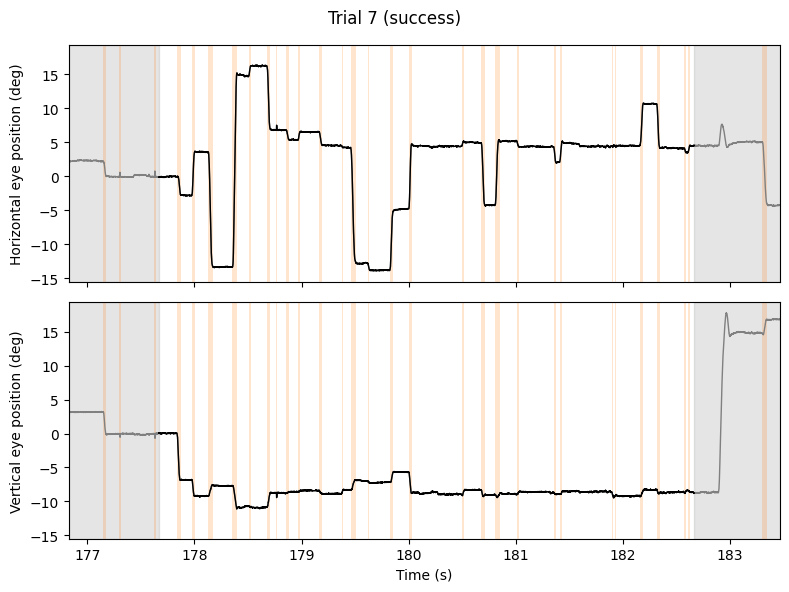

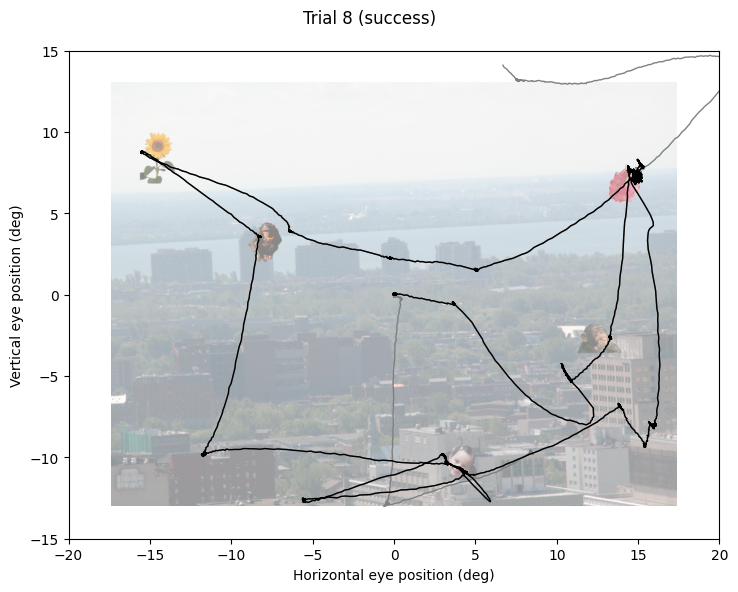

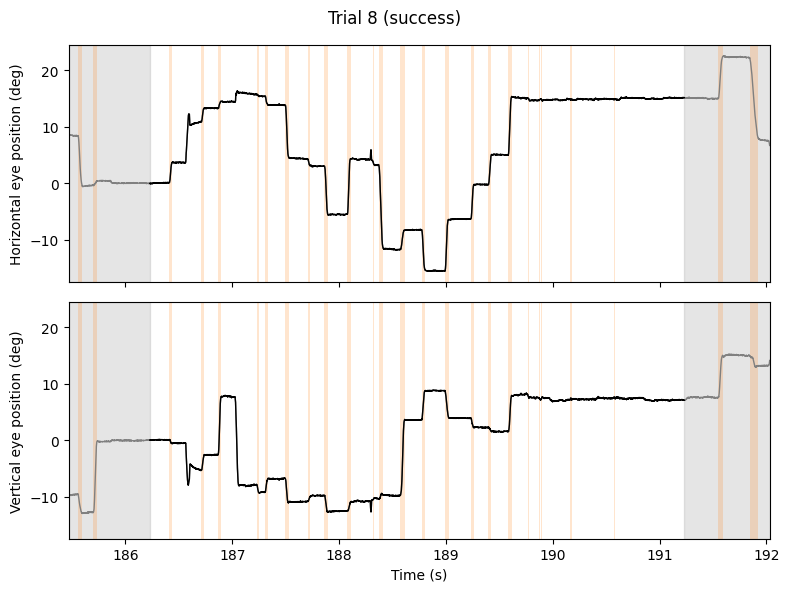

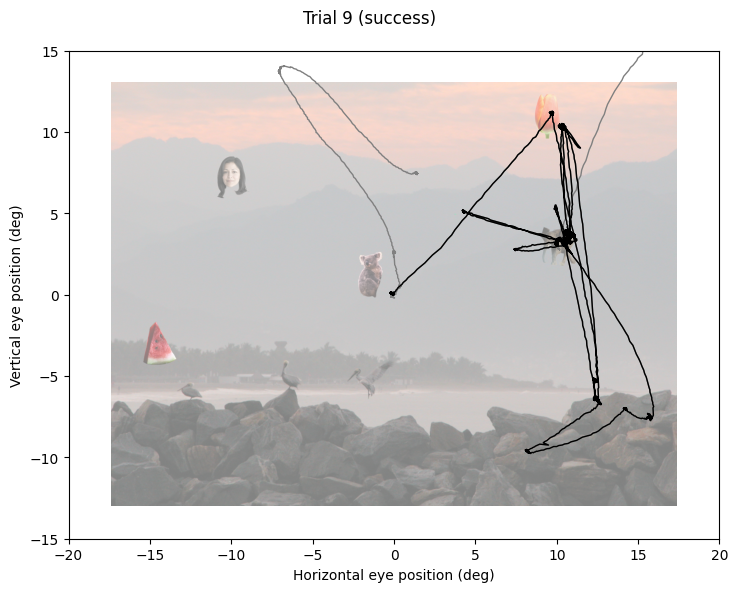

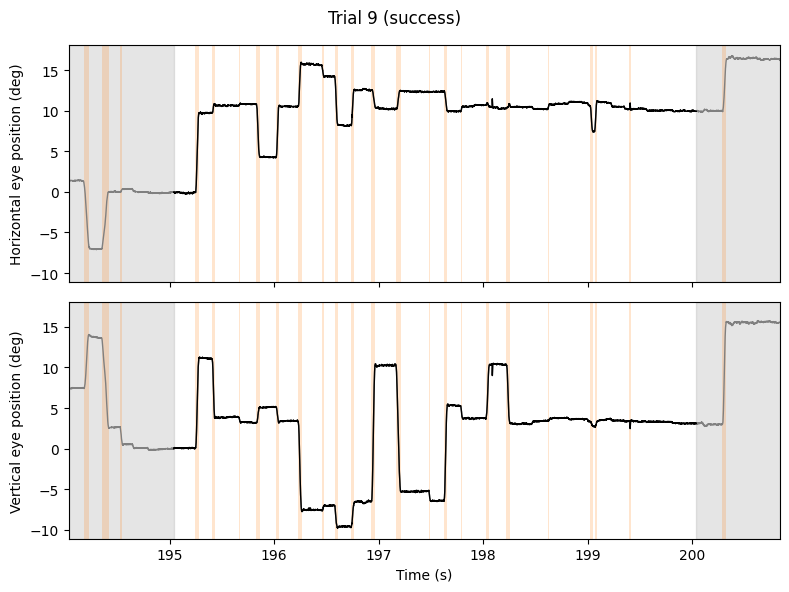

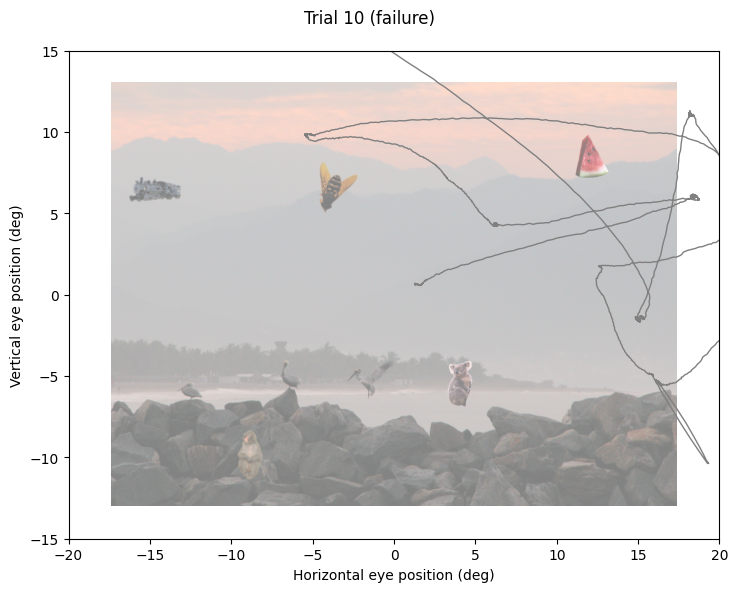

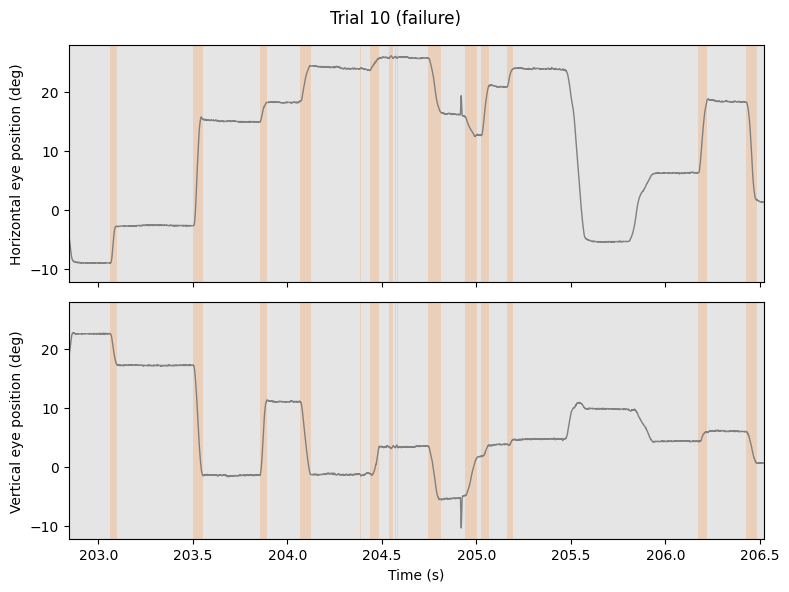

In [2]:
%matplotlib inline
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib import image
import os

# Data specification
basedir = "/projects/nextcloud_data/csng_test/files/Latency_shortening"
datadir = os.path.join(basedir, "data")
data_filename = "HIME_20140904_rec5_blk2_eye_position.hdf5"
stimdir = os.path.join(basedir, "stimuli")

# Load session-wide parameters from the datafile
with h5py.File(f"{datadir}/{data_filename}", 'r') as data:
    num_trials = data['/number_of_trials'][...]
    pxlperdeg = data['/pixel_per_degree'][...]
    stimsetname = data['/stimulus_set_name'][...].astype('str')

num_trials = min(num_trials, n_trials_to_plot)
    
for trial_id in range(1, num_trials + 1):
    # Load data and trial-specific parameters from the datafile
    trial_label = f"/trial{trial_id}"
    with h5py.File(f"{datadir}/{data_filename}", 'r') as data:
        eyepos = data[trial_label+"/eye_position"][...]
        t_start = data[trial_label+"/trial_start_time"][...]
        t_img_on = data[trial_label+"/image_onset_time"][...]
        t_img_off = data[trial_label+"/image_offset_time"][...]
        t_end = data[trial_label+"/trial_end_time"][...]
        img_id = data[trial_label+"/stimulus_image_id"][...]
        success = data[trial_label+"/success"][...]
        ts_sac_on = data[trial_label+"/saccade_onset_times"][...]
        ts_sac_off = data[trial_label+"/saccade_offset_times"][...]

    num_samples = eyepos.shape[0]
    times = np.linspace(t_start, t_end, num_samples)
    mask_fv = (t_img_on < times) & (times < t_img_off)

    # Load the stimulus image file
    img = image.imread(f"{stimdir}/{stimsetname}/{img_id}.png")
    height, width = img.shape[:2]
    img_extent = (-width / 2 / pxlperdeg, width / 2 / pxlperdeg, -height / 2 / pxlperdeg, height / 2 / pxlperdeg)

    # Draw plots
    fig1 = plt.figure(figsize=(8, 6))
    ax = fig1.add_subplot(1, 1, 1)
    fig1.suptitle(f"Trial {trial_id} ({'success' if success else 'failure'})")
    ax.set_xlabel("Horizontal eye position (deg)")
    ax.set_ylabel("Vertical eye position (deg)")
    ax.set_xlim(-20, 20)
    ax.set_ylim(-15, 15)
    ax.set_aspect(1)
    ax.imshow(img, extent=img_extent, alpha=0.5)
    ax.plot(eyepos[:, 0], eyepos[:, 1], lw=1, color='gray')
    ax.plot(eyepos[mask_fv, 0], eyepos[mask_fv, 1], lw=1, color='black')
    fig1.tight_layout()

    fig2, axes = plt.subplots(2, 1, figsize=(8, 6), sharex='all', sharey='all')
    fig2.suptitle(f"Trial {trial_id} ({'success' if success else 'failure'})")
    axes[0].set_ylabel("Horizontal eye position (deg)")
    axes[1].set_ylabel("Vertical eye position (deg)")
    axes[1].set_xlabel("Time (s)")
    for i_ax, ax in enumerate(axes):
        ax.plot(times, eyepos[:, i_ax], lw=1, color='gray')
        ax.plot(times[mask_fv], eyepos[mask_fv, i_ax], lw=1, color='black')
        ax.axvspan(t_start, t_img_on, color='gray', alpha=0.2)
        ax.axvspan(t_img_off, t_end, color='gray', alpha=0.2)
        for t_on, t_off in zip(ts_sac_on, ts_sac_off):
            ax.axvspan(t_on, t_off, color='C1', alpha=0.2, lw=0)
        ax.set_xlim(t_start, t_end)
    fig2.tight_layout()

    plt.show()